In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import optuna

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = './datasets/datasets_setimen_no_processing.csv'

In [3]:
try:
    df = pd.read_csv(file_path)
    if 'label' in df.columns and 'bert_sentiment' not in df.columns: df.rename(columns={'label': 'bert_sentiment'}, inplace=True)
    print("File CSV berhasil dimuat.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{file_path}'.")
   

File CSV berhasil dimuat.


In [4]:
print("\n--- 1. Exploratory Data Analysis (EDA) ---")
print("Info Dataset:")
df.info()
print("\n5 Baris Pertama:")
print(df.head())
print("\nDistribusi Label:")
print(df['bert_sentiment'].value_counts())


--- 1. Exploratory Data Analysis (EDA) ---
Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9262 entries, 0 to 9261
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      9262 non-null   int64  
 1   created_at               9262 non-null   object 
 2   favorite_count           9262 non-null   int64  
 3   full_text                9262 non-null   object 
 4   id_str                   9262 non-null   int64  
 5   image_url                534 non-null    object 
 6   in_reply_to_screen_name  5724 non-null   object 
 7   lang                     9262 non-null   object 
 8   location                 2051 non-null   object 
 9   quote_count              9262 non-null   int64  
 10  reply_count              9262 non-null   int64  
 11  retweet_count            9262 non-null   int64  
 12  tweet_url                9262 non-null   object 
 13  user_id_str         

# --- 1. Exploratory Data Analysis (EDA) ---


Visualisasi EDA disimpan sebagai 'label_distribution.png'


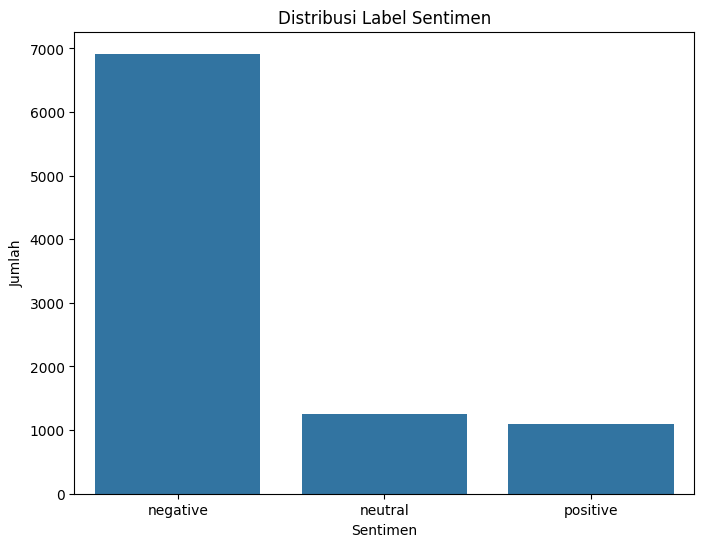

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='bert_sentiment', data=df, order=df['bert_sentiment'].value_counts().index)
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.savefig('label_distribution.png')
print("\nVisualisasi EDA disimpan sebagai 'label_distribution.png'")


# --- 2. Persiapan Data ---

In [6]:
print("\n--- 2. Persiapan Data ---")
X = df['text_clean']
y = df['bert_sentiment']



--- 2. Persiapan Data ---


In [7]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
y_encoded = y.map(label_map)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Ukuran data latih: {X_train.shape[0]}")
print(f"Ukuran data uji: {X_test.shape[0]}")

Ukuran data latih: 7409
Ukuran data uji: 1853


# --- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) ---

In [9]:
print("\n--- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) dengan SMOTE ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train); X_test_tfidf = tfidf_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
svm_model = SVC(kernel='linear', random_state=42); svm_model.fit(X_train_resampled, y_train_resampled)
nb_model = MultinomialNB(); nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_tfidf); y_pred_nb = nb_model.predict(X_test_tfidf)
report_svm = classification_report(y_test, y_pred_svm, target_names=label_map.keys(), output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, target_names=label_map.keys(), output_dict=True)
results = {'SVM (dengan SMOTE)': report_svm['weighted avg'], 'Naive Bayes (dengan SMOTE)': report_nb['weighted avg']}
print("Hasil Skenario 1 (Baseline dengan SMOTE) selesai.")


--- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) dengan SMOTE ---
Hasil Skenario 1 (Baseline dengan SMOTE) selesai.


# --- PENAMBAHAN: HITUNG CLASS WEIGHT ---

In [10]:
print("\n--- Menghitung Class Weight untuk Model Deep Learning ---")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Bobot Kelas yang dihitung: {class_weights_tensor}")


--- Menghitung Class Weight untuk Model Deep Learning ---
Bobot Kelas yang dihitung: tensor([0.4464, 2.4647, 2.8257])


# --- 4. Skenario 2: Model Sekuensial (BiLSTM dengan PyTorch) ---

In [11]:
print("\n--- 4. Skenario 2: Model Sekuensial (BiLSTM) dengan Class Weight ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)
word_counts = Counter(word for text in X_train for word in text.split()); vocab = sorted(word_counts, key=word_counts.get, reverse=True); word_to_idx = {word: i+2 for i, word in enumerate(vocab)}; word_to_idx['<PAD>'] = 0; word_to_idx['<UNK>'] = 1
def text_to_sequence(text, word_to_idx): return [word_to_idx.get(word, 1) for word in text.split()]
X_train_seq = [text_to_sequence(text, word_to_idx) for text in X_train]; X_test_seq = [text_to_sequence(text, word_to_idx) for text in X_test]
def pad_sequences(sequences, max_len=100):
    padded = np.zeros((len(sequences), max_len), dtype=np.int64);
    for i, seq in enumerate(sequences):
        seq_len = len(seq)
        if seq_len > 0: padded[i, :min(seq_len, max_len)] = seq[:max_len]
    return padded
X_train_pad = pad_sequences(X_train_seq); X_test_pad = pad_sequences(X_test_seq)
class SentimentDataset(Dataset):
    def __init__(self, X, y): self.X = torch.from_numpy(X).long(); self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]
train_dataset_lstm = SentimentDataset(X_train_pad, y_train.to_numpy()); test_dataset_lstm = SentimentDataset(X_test_pad, y_test.to_numpy())
train_loader = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True); test_loader = DataLoader(test_dataset_lstm, batch_size=32)
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, n_layers=2, dropout=0.3):
        super().__init__(); self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0); self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout); self.fc = nn.Linear(hid_dim * 2, out_dim); self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        embedded = self.dropout(self.embedding(text)); outputs, (hidden, cell) = self.lstm(embedded); hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)); return self.fc(hidden)
bilstm_model = BiLSTMClassifier(len(word_to_idx), 128, 64, 3).to(device)
optimizer = torch.optim.Adam(bilstm_model.parameters())
# --- Masukkan bobot ke loss function ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

print("Memulai pelatihan BiLSTM..."); bilstm_model.train()
for epoch in range(15):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device); optimizer.zero_grad(); output = bilstm_model(data); loss = criterion(output, target); loss.backward(); optimizer.step()
    print(f'Epoch BiLSTM: {epoch+1}, Loss: {loss.item():.4f}')
bilstm_model.eval(); all_preds = []
with torch.no_grad():
    for data, target in test_loader:
        outputs = bilstm_model(data.to(device)); _, predicted = torch.max(outputs.data, 1); all_preds.extend(predicted.cpu().numpy())
y_pred_bilstm = np.array(all_preds)
report_bilstm = classification_report(y_test, y_pred_bilstm, target_names=label_map.keys(), output_dict=True)
results['BiLSTM (Class Weight)'] = report_bilstm['weighted avg']
print("Hasil Skenario 2 (BiLSTM dengan Class Weight) selesai.")


--- 4. Skenario 2: Model Sekuensial (BiLSTM) dengan Class Weight ---
Memulai pelatihan BiLSTM...
Epoch BiLSTM: 1, Loss: 1.3383
Epoch BiLSTM: 2, Loss: 0.8166
Epoch BiLSTM: 3, Loss: 0.2503
Epoch BiLSTM: 4, Loss: 0.1753
Epoch BiLSTM: 5, Loss: 0.3821
Epoch BiLSTM: 6, Loss: 0.1612
Epoch BiLSTM: 7, Loss: 0.1189
Epoch BiLSTM: 8, Loss: 0.1252
Epoch BiLSTM: 9, Loss: 0.4780
Epoch BiLSTM: 10, Loss: 0.2369
Epoch BiLSTM: 11, Loss: 0.1767
Epoch BiLSTM: 12, Loss: 0.1226
Epoch BiLSTM: 13, Loss: 0.1677
Epoch BiLSTM: 14, Loss: 0.0080
Epoch BiLSTM: 15, Loss: 0.0495
Hasil Skenario 2 (BiLSTM dengan Class Weight) selesai.


# --- 5. Skenario 3: Model Transformer (IndoBERT) ---

In [ ]:
print("\n--- 5. Skenario 3: IndoBERT dengan Class Weight ---")
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)
train_df_hf = pd.DataFrame({'text': X_train.to_list(), 'label': y_train.to_list()})
test_df_hf = pd.DataFrame({'text': X_test.to_list(), 'label': y_test.to_list()})
train_dataset_hf = HFDataset.from_pandas(train_df_hf)
test_dataset_hf = HFDataset.from_pandas(test_df_hf)
def tokenize_function(examples): return tokenizer_bert(examples['text'], padding='max_length', truncation=True, max_length=128)
train_tokenized = train_dataset_hf.map(tokenize_function, batched=True)
test_tokenized = test_dataset_hf.map(tokenize_function, batched=True)
def model_init(): return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
def compute_metrics(p): preds = np.argmax(p.predictions, axis=1); return {"accuracy": accuracy_score(p.label_ids, preds)}
def objective(trial):
    training_args = TrainingArguments(
        output_dir='./results_optuna',
        eval_strategy="epoch",
        save_strategy="epoch",  
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        per_device_train_batch_size=8,
        num_train_epochs=trial.suggest_int("num_train_epochs", 2, 5),
        weight_decay=trial.suggest_float("weight_decay", 0.01, 0.1),
        logging_steps=500,
        disable_tqdm=True,
    )
    trainer = CustomTrainer(model_init=model_init, args=training_args, train_dataset=train_tokenized, eval_dataset=test_tokenized, compute_metrics=compute_metrics)
    trainer.train()
    return trainer.evaluate()['eval_accuracy']

print("Memulai optimalisasi hyperparameter untuk IndoBERT...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Hyperparameter terbaik:", study.best_params)

final_training_args = TrainingArguments(
    output_dir='./results_final',
    eval_strategy="epoch",
    save_strategy="epoch",  
    learning_rate=study.best_params['learning_rate'],
    per_device_train_batch_size=8,
    num_train_epochs=study.best_params['num_train_epochs'],
    weight_decay=study.best_params['weight_decay'],
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
)
final_trainer = CustomTrainer(model_init=model_init, args=final_training_args, train_dataset=train_tokenized, eval_dataset=test_tokenized, compute_metrics=compute_metrics)
print("Memulai fine-tuning final IndoBERT...")
final_trainer.train()
predictions = final_trainer.predict(test_tokenized)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
report_bert = classification_report(y_test, y_pred_bert, target_names=label_map.keys(), output_dict=True)
results['IndoBERT (Class Weight)'] = report_bert['weighted avg']
print("Hasil Skenario 3 (IndoBERT dengan Class Weight) selesai.")

# --- 6. Perbandingan Akhir ---


--- 6. Perbandingan Akhir Semua Model ---
                            Accuracy  Precision    Recall  F1-Score
SVM (dengan SMOTE)          0.798165   0.815831  0.798165  0.804796
Naive Bayes (dengan SMOTE)  0.693470   0.778930  0.693470  0.717396
BiLSTM (Class Weight)       0.847275   0.848049  0.847275  0.845886
IndoBERT (Class Weight)     0.852132   0.891507  0.852132  0.861673

Plot perbandingan disimpan sebagai 'model_comparison_all.png'
Confusion matrix IndoBERT disimpan sebagai 'confusion_matrix_indobert.png'


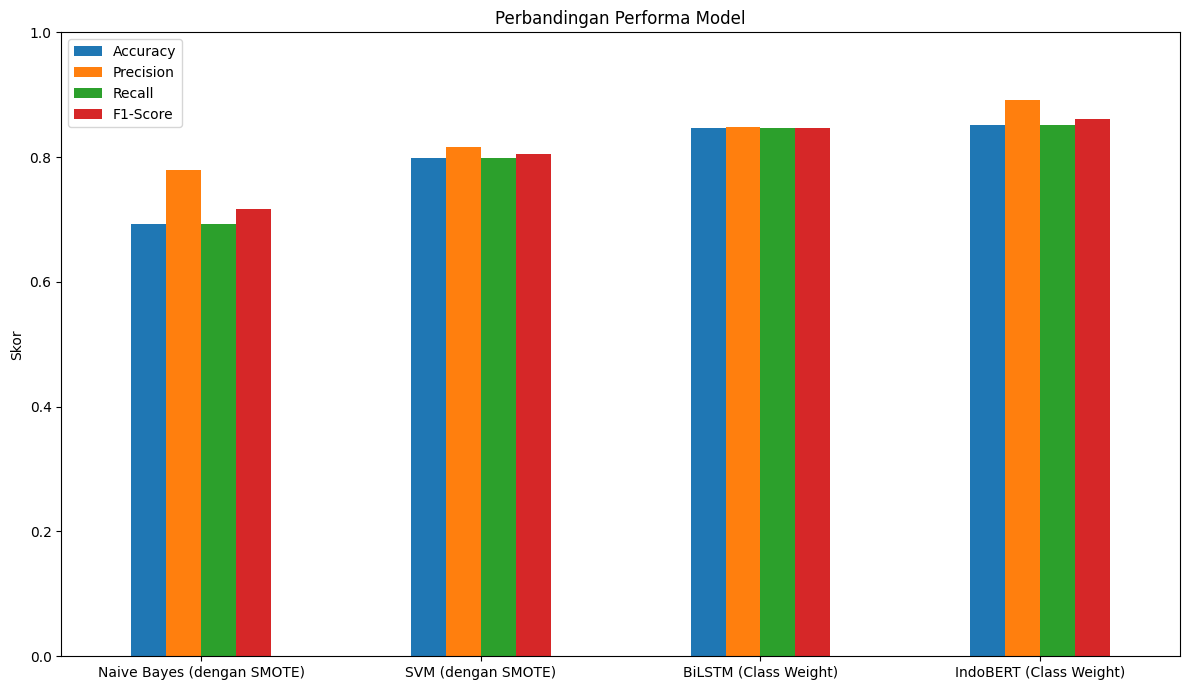

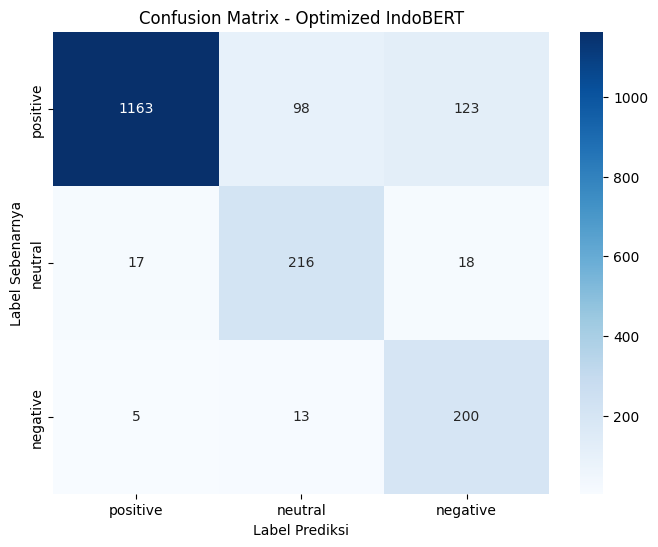

In [14]:
print("\n--- 6. Perbandingan Akhir Semua Model ---")
results_df = pd.DataFrame(results).T
results_df.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score'}, inplace=True)
results_df['Accuracy'] = [
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_bilstm),
    accuracy_score(y_test, y_pred_bert)
]
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
print(results_df)

results_df.sort_values('F1-Score').plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Perbandingan Performa Model')
plt.ylabel('Skor')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('model_comparison_all.png')
print("\nPlot perbandingan disimpan sebagai 'model_comparison_all.png'")

cm = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - Optimized IndoBERT')
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.savefig('confusion_matrix_indobert.png')
print("Confusion matrix IndoBERT disimpan sebagai 'confusion_matrix_indobert.png'")

In [15]:
print("\n--- 7. Mengekspor Model dan Tokenizer ---")
export_directory = "indobert_fomo_model_final"
final_trainer.save_model(export_directory)
tokenizer_bert.save_pretrained(export_directory)
print(f"Model dan Tokenizer berhasil diekspor ke direktori: '{export_directory}'")


--- 7. Mengekspor Model dan Tokenizer ---
Model dan Tokenizer berhasil diekspor ke direktori: 'indobert_fomo_model_final'
